In [1]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 60.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00


In [36]:
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from nltk.util import ngrams
from nltk.corpus import stopwords
import nltk
import joblib
import re
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [5]:
# Load dataset
def load_data():
    df = pd.read_csv("amazonreviews.tsv", sep='\t')
    return df

In [7]:
df = load_data()
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [9]:
df.size

14206

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7103 entries, 0 to 7102
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   7103 non-null   object
 1   review  7103 non-null   object
dtypes: object(2)
memory usage: 111.1+ KB


In [12]:
df.describe()

,label,review
count,7103,7103
unique,2,7103
top,neg,Takes FOREVER: I noticed some reviews saying t...
freq,3660,1


<ipython-input-17-96b612b436a7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


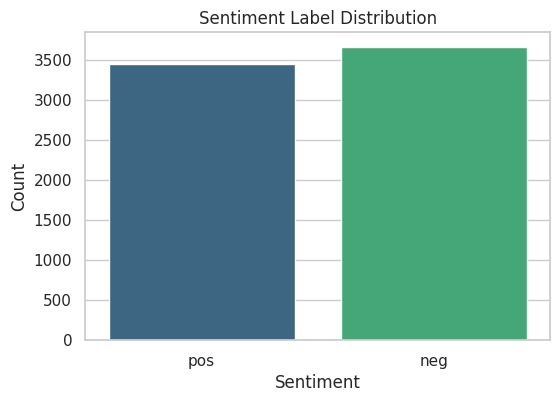

In [17]:
# Plot sentiment label distribution
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='label', palette='viridis')
plt.title("Sentiment Label Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [18]:
# Add a column for review length
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df

,label,review,review_length
0,pos,Stuning even for the non-gamer: This sound tra...,80
1,pos,The best soundtrack ever to anything.: I'm rea...,97
2,pos,Amazing!: This soundtrack is my favorite music...,129
3,pos,Excellent Soundtrack: I truly like this soundt...,118
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",87
...,...,...,...
7098,neg,Cannot be used with Playtex Nurser Bottles: I ...,27
7099,neg,So HOT it caught on FIRE!!!: Purchased this it...,113
7100,neg,Didn't warm at all!!: It seems like all of the...,84
7101,neg,Don't waste your money: I purchased this in ho...,119


In [19]:
# Review length statistics
print("Review Length Stats:")
print(df['review_length'].describe())

Review Length Stats:
count    7103.000000
mean       79.003801
std        42.842203
min        15.000000
25%        43.000000
50%        70.000000
75%       108.000000
max       212.000000
Name: review_length, dtype: float64


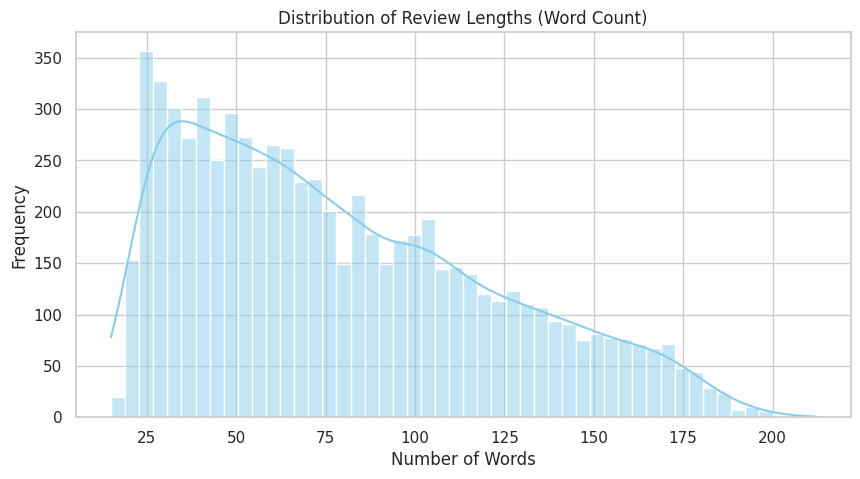

In [20]:
# Plot review length distribution
plt.figure(figsize=(10, 5))
sns.histplot(df['review_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Review Lengths (Word Count)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

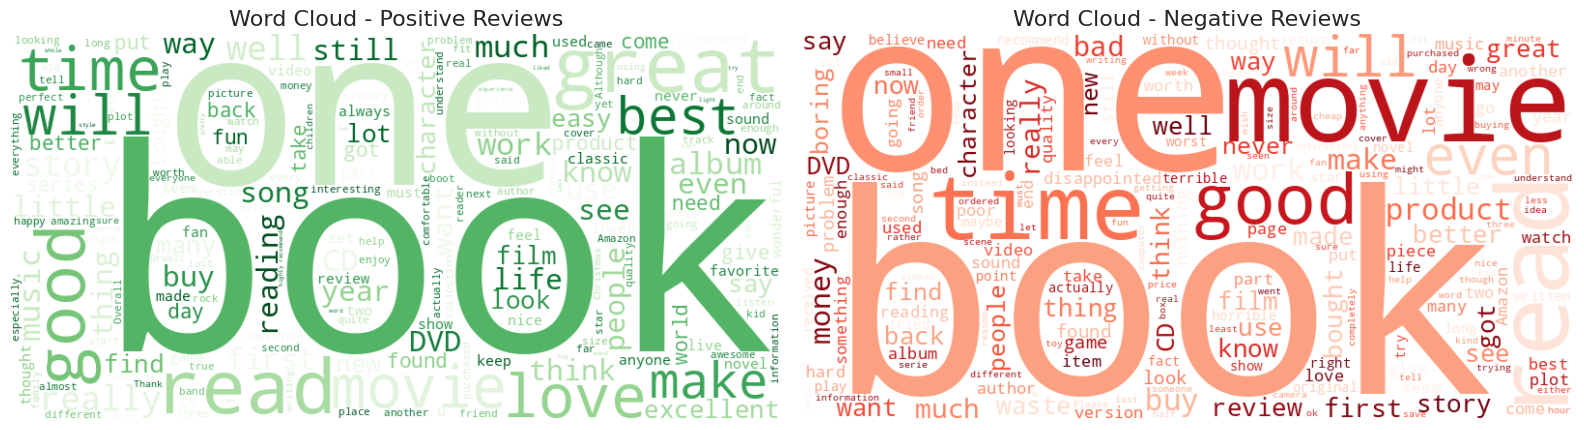

In [22]:
# Separate positive and negative reviews
positive_reviews = df[df['label'] == 'pos']['review']
negative_reviews = df[df['label'] == 'neg']['review']
# Create word clouds
positive_text = " ".join(positive_reviews)
negative_text = " ".join(negative_reviews)
positive_wc = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_text)

# Plot word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Positive Reviews", fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - Negative Reviews", fontsize=16)

plt.tight_layout()
plt.show()

In [39]:
# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')# Tokenization & Stopword removal
nltk.download('punkt_tab') # Download the punkt_tab data package

stop_words = set(stopwords.words('english'))
df['tokens'] = df['cleaned_review'].apply(lambda x: [word for word in word_tokenize(x) if word not in stop_words])

# Frequency counters
def get_top_n_words(tokens, n=20):
    return Counter([word for review in tokens for word in review]).most_common(n)

pos_tokens = df[df['label'] == 'pos']['tokens']
neg_tokens = df[df['label'] == 'neg']['tokens']

top_pos = get_top_n_words(pos_tokens)
top_neg = get_top_n_words(neg_tokens)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


<ipython-input-40-7834ab3c2241>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


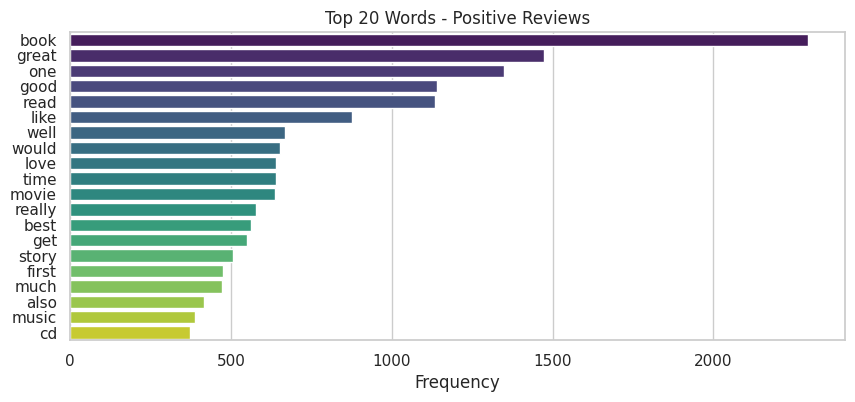

<ipython-input-40-7834ab3c2241>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette='viridis')


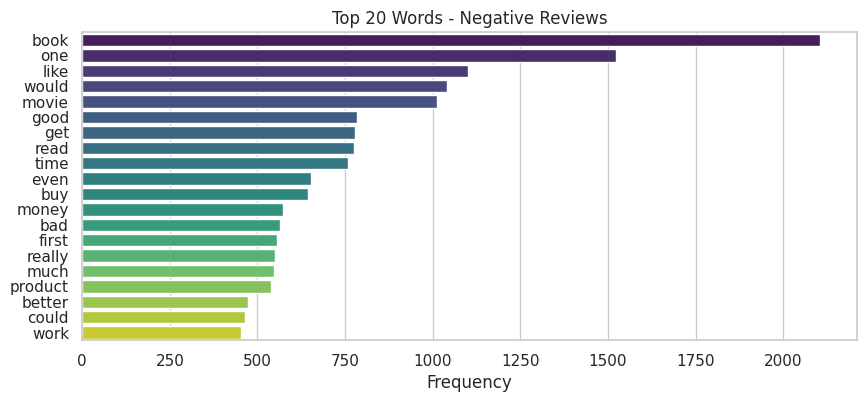

In [40]:
# Plot top words
def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 4))
    sns.barplot(x=list(counts), y=list(words), palette='viridis')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.show()

plot_top_words(top_pos, "Top 20 Words - Positive Reviews")
plot_top_words(top_neg, "Top 20 Words - Negative Reviews")

In [41]:
# N-gram analysis
def get_ngrams(tokens_list, n=2, top=20):
    ngram_counts = Counter()
    for tokens in tokens_list:
        ngram_counts.update(ngrams(tokens, n))
    return ngram_counts.most_common(top)


<ipython-input-42-e305d54564bf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette='coolwarm')


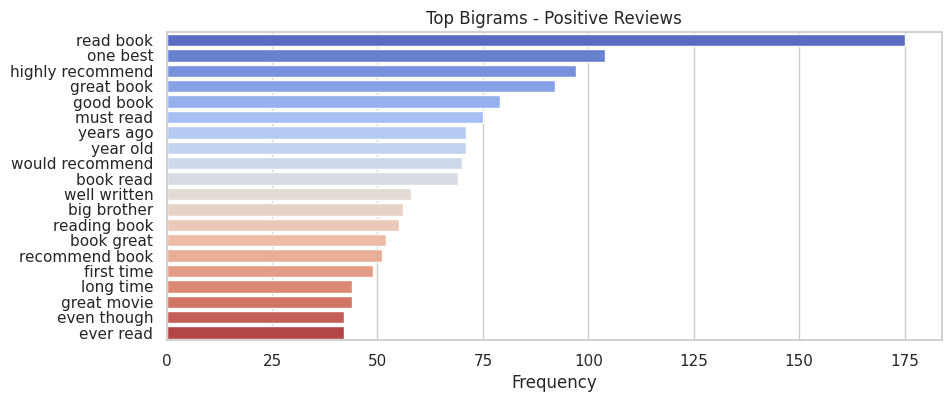

<ipython-input-42-e305d54564bf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette='coolwarm')


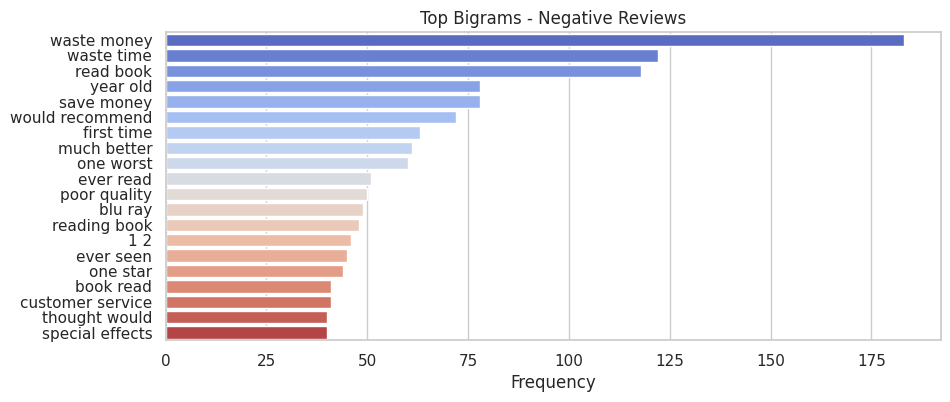

<ipython-input-42-e305d54564bf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette='coolwarm')


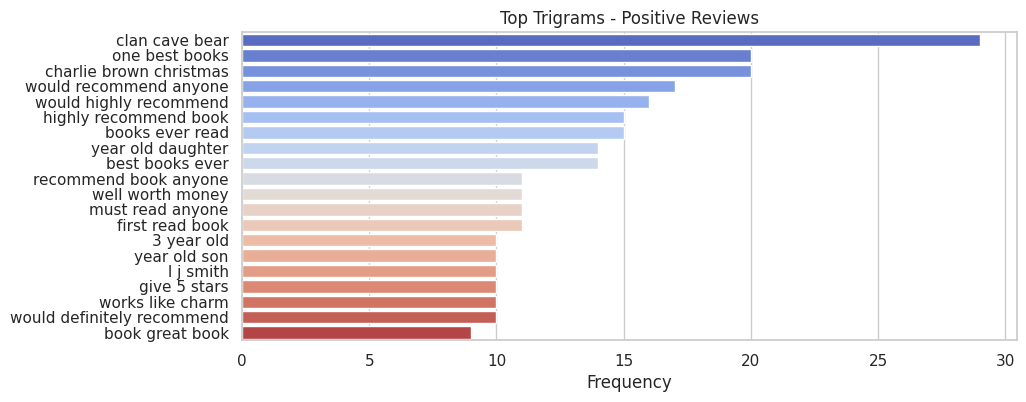

<ipython-input-42-e305d54564bf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=labels, palette='coolwarm')


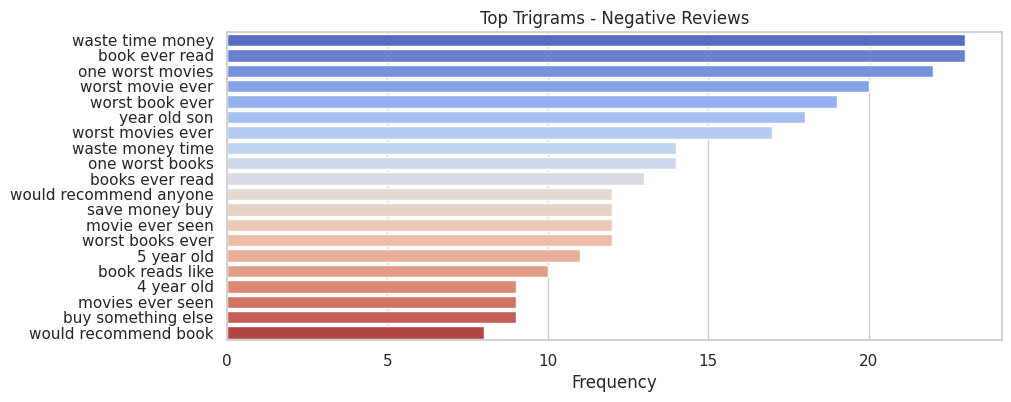

In [42]:
# Plot n-grams
def plot_ngrams(ngram_data, title):
    labels = [' '.join(ng) for ng, _ in ngram_data]
    counts = [cnt for _, cnt in ngram_data]
    plt.figure(figsize=(10, 4))
    sns.barplot(x=counts, y=labels, palette='coolwarm')
    plt.title(title)
    plt.xlabel("Frequency")
    plt.show()

plot_ngrams(get_ngrams(pos_tokens, 2), "Top Bigrams - Positive Reviews")
plot_ngrams(get_ngrams(neg_tokens, 2), "Top Bigrams - Negative Reviews")
plot_ngrams(get_ngrams(pos_tokens, 3), "Top Trigrams - Positive Reviews")
plot_ngrams(get_ngrams(neg_tokens, 3), "Top Trigrams - Negative Reviews")


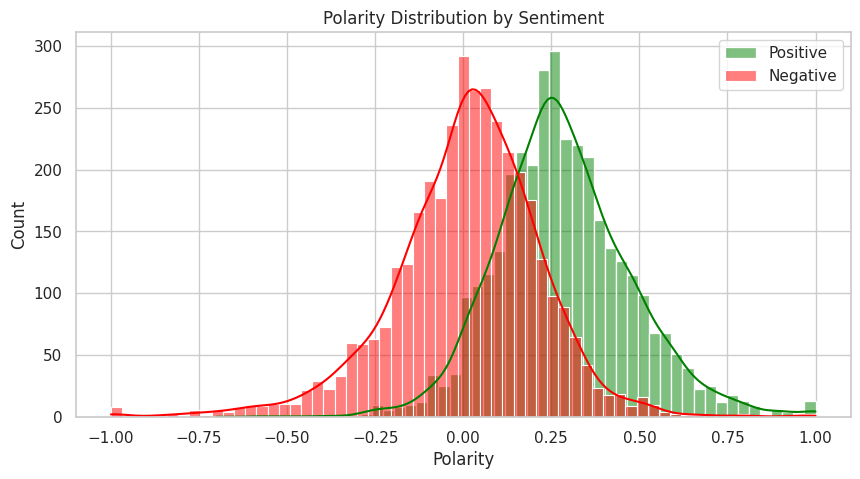

In [44]:
from textblob import TextBlob
# Sentiment scoring with TextBlob
df['polarity'] = df['review'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Plot sentiment polarity
plt.figure(figsize=(10, 5))
sns.histplot(df[df['label'] == 'pos']['polarity'], color='green', label='Positive', kde=True)
sns.histplot(df[df['label'] == 'neg']['polarity'], color='red', label='Negative', kde=True)
plt.title("Polarity Distribution by Sentiment")
plt.xlabel("Polarity")
plt.legend()
plt.show()

In [23]:
# Data Cleaning Function
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [24]:
# Preprocess data
def preprocess_data(df):
    df['cleaned_review'] = df['review'].apply(clean_text)
    label_encoder = LabelEncoder()
    df['encoded_label'] = label_encoder.fit_transform(df['label'])
    return df, label_encoder

In [25]:
# Train models
def train_models(X_train_tfidf, X_test_tfidf, y_train, y_test):
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train_tfidf, y_train)

    nb = MultinomialNB()
    nb.fit(X_train_tfidf, y_train)

    y_pred_lr = log_reg.predict(X_test_tfidf)
    y_pred_nb = nb.predict(X_test_tfidf)

    return log_reg, nb, accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_nb)


In [26]:
# Load and process data
df = load_data()
df, label_encoder = preprocess_data(df)

In [27]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], df['encoded_label'], test_size=0.2, random_state=42, stratify=df['encoded_label']
)

In [28]:
# Convert text to numerical features
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [52]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


In [55]:
# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Support Vector Machine": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

# Train and evaluate models
for name, model in models.items():
    print(f"\n🧪 Model: {name}")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))


🧪 Model: Logistic Regression
Accuracy: 0.8529204785362421
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       732
           1       0.84      0.86      0.85       689

    accuracy                           0.85      1421
   macro avg       0.85      0.85      0.85      1421
weighted avg       0.85      0.85      0.85      1421


🧪 Model: Naive Bayes
Accuracy: 0.8395496129486277
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       732
           1       0.85      0.82      0.83       689

    accuracy                           0.84      1421
   macro avg       0.84      0.84      0.84      1421
weighted avg       0.84      0.84      0.84      1421


🧪 Model: Support Vector Machine
Accuracy: 0.860661505981703
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       732
           1       0.85      0.87      0.86       689

    accurac

In [29]:
# Train models
log_reg, nb, lr_acc, nb_acc = train_models(X_train_tfidf, X_test_tfidf, y_train, y_test)


In [45]:
# Save model and vectorizer
joblib.dump(log_reg, "logistic_regression_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

In [46]:
# Streamlit app
def app():
    st.title("Sentiment Analysis App")
    model = joblib.load("logistic_regression_model.pkl")
    vectorizer = joblib.load("tfidf_vectorizer.pkl")

    user_input = st.text_area("Enter a review:")
    if st.button("Analyze Sentiment"):
        cleaned_text = clean_text(user_input)
        vectorized_text = vectorizer.transform([cleaned_text])
        prediction = model.predict(vectorized_text)[0]
        sentiment = "Positive" if prediction == 1 else "Negative"
        st.write(f"Sentiment: {sentiment}")

if __name__ == "__main__":
    app()


2025-04-04 06:12:59.965 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 06:13:00.092 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-04-04 06:13:00.095 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 06:13:00.153 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 06:13:00.154 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 06:13:00.158 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 06:13:00.159 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-04-04 06:13:00.160 Session state does not 

In [47]:
!wget -q -O - ipv4.icanhazip.com

34.80.194.192


In [56]:
! streamlit run app.py & npx localtunnel --port 8501

⠙

⠹⠸⠼⠴
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.80.194.192:8501

⠦your url is: https://modern-wombats-sing.loca.lt
  Stopping...
^C
